<a href="https://colab.research.google.com/github/Dimildizio/system_design/blob/main/metrics_translate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Check metrics for a specific dataset

## Installs

In [1]:
%%capture
!pip install rouge-score sacrebleu sentencepiece

## Imports

In [54]:
import pandas as pd
import sentencepiece as sp
import sacrebleu
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from sacrebleu.metrics import BLEU, CHRF

import matplotlib.pyplot as plt


In [4]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
FILENAME = 'all_translations.tsv'

##Load dataset

In [11]:
df = pd.read_csv(FILENAME, sep='\t')

,ru,en_expert,en_auto,en_google,en_nllb,en_marian
0,На основе данной модели реализован эксперимент...,An experimental method is implemented based on...,Based on this model is implemented experimenta...,"Based on this model, an experimental method is...","Based on this model, an experimental method ha...","On the basis of this model, an experimental me..."


## Create metrics

#### aux rounding func

In [14]:
def round_perc(num: float) -> float:
  return round(num*100, 2)

### Rouge

In [12]:
Rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

In [22]:
def eval_rouge(translation, reference):
  rouge_dict = {'rouge1':0,
                'rouge2':0,
                'rougeL':0
                }
  rouges = Rouge.score(reference, translation)
  for key in rouges.keys():
    rouge_dict[key] += rouges[key].fmeasure
  return round_perc(pd.Series(rouge_dict.values()).mean())

### BLEU

In [13]:
smoothing_zero_ngrams = SmoothingFunction()

In [260]:
def get_sent_bleu(sentence: str, reference: str) -> float:
  score = sentence_bleu([reference.split()], sentence.split(),
                        weights = (0.25, 0.5, 0.25), smoothing_function=smoothing_zero_ngrams.method1)
  return round_perc(score)


def get_bleu(sentence: str, reference: str) -> float:
  score = corpus_bleu([[reference.split()]], [sentence.split()],
                      smoothing_function=smoothing_zero_ngrams.method1)
  return round_perc(score)

def get_sacrebleu(sent_series, ref_series): #crutch
  #irrelevant scores
  for sent, ref in zip(sent_series, ref_series):
    return sacrebleu.corpus_bleu([sent], [[ref]])

def get_chrf(sentence, reference):
  chrf = CHRF()
  return round(chrf.corpus_score([sentence], [[reference]]).score,2)


### meteor

In [122]:
def get_meteor(sentence: str, reference: str) -> float:
  score = meteor_score([reference.split()], sentence.split())
  return round_perc(score)

TER

In [17]:
def ter(hypothesis, reference):
    n = len(reference)
    m = len(hypothesis)

    dp = [[0] * (m + 1) for _ in range(n + 1)]

    for i in range(n + 1):
        dp[i][0] = i
    for j in range(m + 1):
        dp[0][j] = j

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = 0 if reference[i - 1] == hypothesis[j - 1] else 1
            dp[i][j] = min(dp[i - 1][j] + 1, dp[i][j - 1] + 1, dp[i - 1][j - 1] + cost)
    return dp[n][m]

###Metrics

In [273]:
metrics = {'sent bleu': get_sent_bleu,
          'bleu':  get_bleu,
          'rogue': eval_rouge,
          'meteor': get_meteor,
           'TER':ter,
           #'sacre bleu': get_sacrebleu,
           'CHRF++': get_chrf
          }

## Test functions

In [265]:
def apply_func(func, df=df):
  scores = pd.DataFrame(columns=df.columns[2:])
  for col in df.columns[2:]:
    scores[col] = df.apply(lambda row: func(row[col], row['en_expert']), axis=1)
  return scores

In [274]:
def test_metric(func, name):
    result = apply_func(func)
    fig, ax = plt.subplots(figsize=(12,6))
    colors = result.plot.area(ax=ax, stacked=False, alpha=0.6).get_lines()

    for i, (col, mean_value) in enumerate(result.mean().items()):   #could also use median
        ax.axhline(y=mean_value, linestyle='--', color=colors[i].get_color(), label=f'Mean {col}: {mean_value:.2f}')

    ax.legend()
    plt.title(name)
    plt.show()

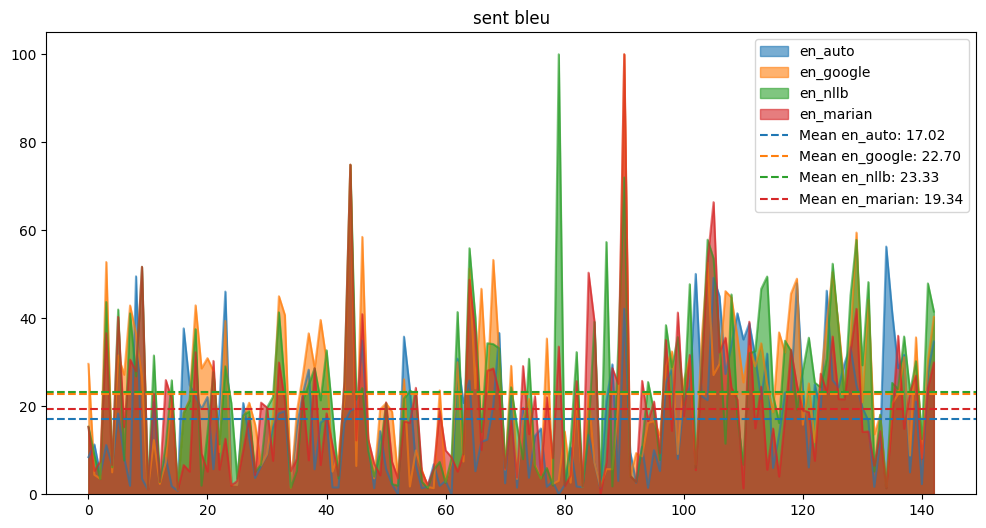

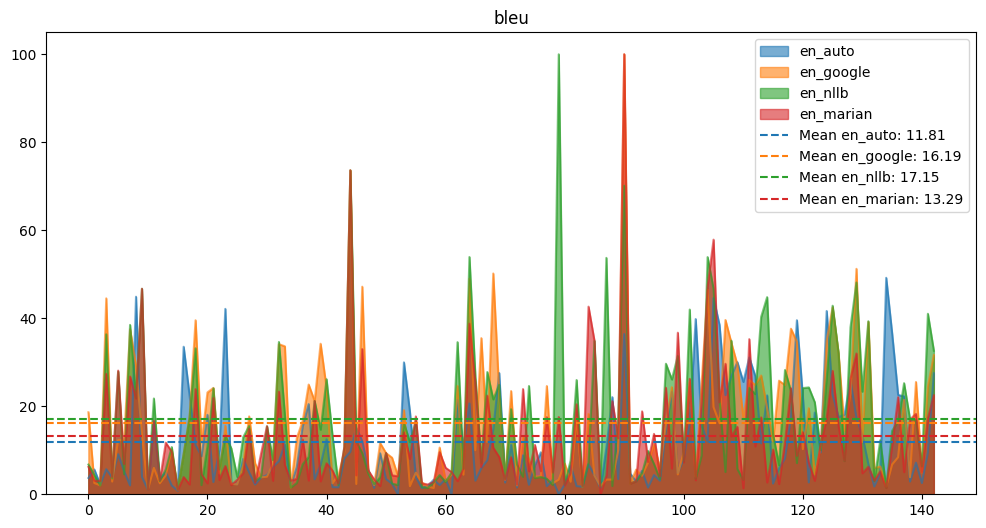

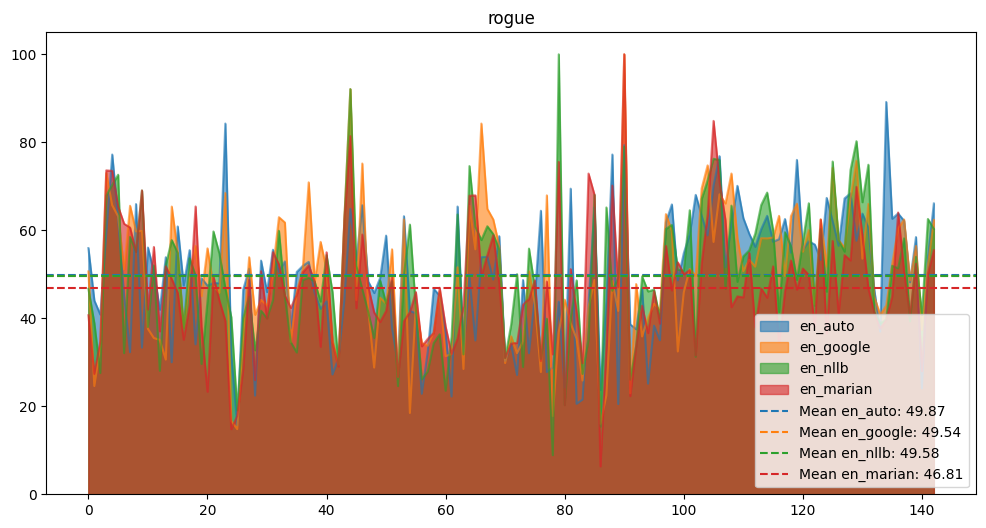

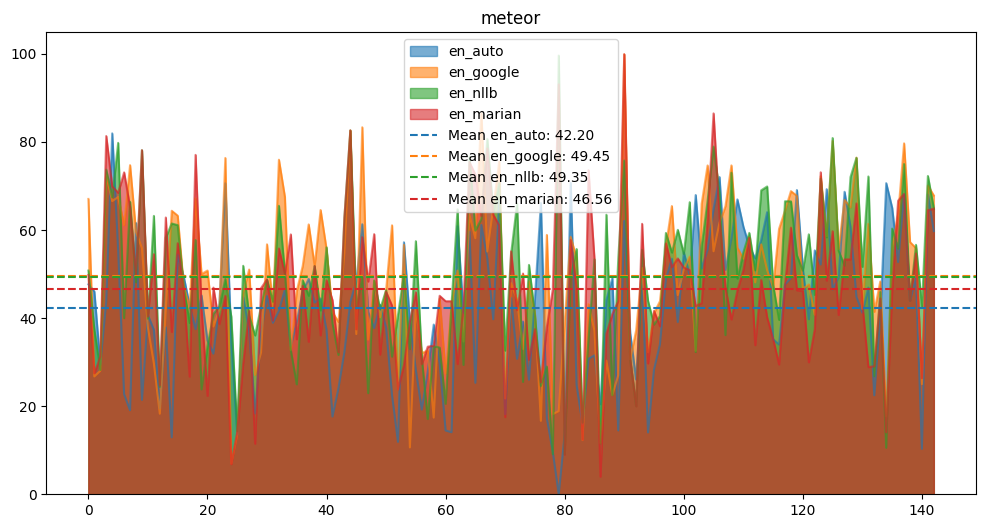

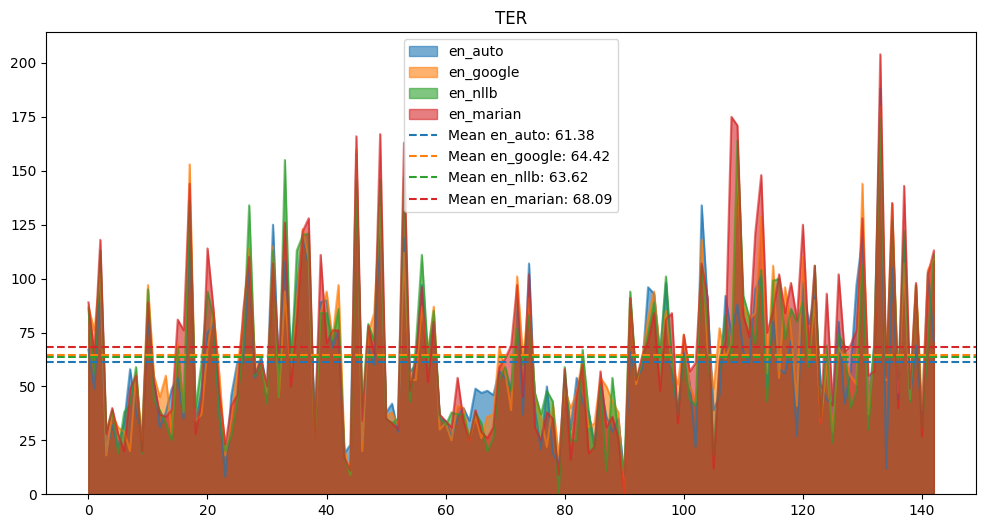

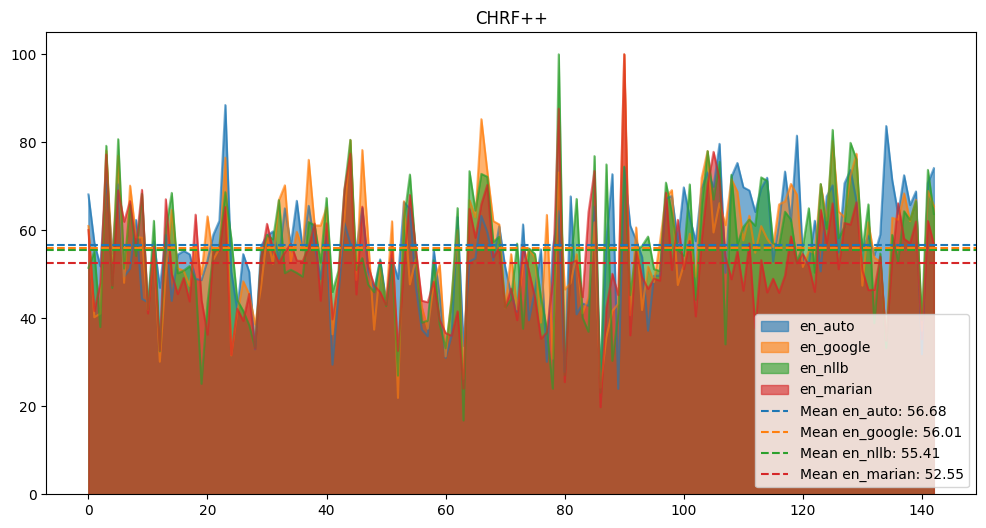

In [275]:
for name, func in metrics.items():
  test_metric(func, name)